# Choose your model (!)

In [1]:
checkpoint_name = 'CTGRLOD-30'

# Load Model

In [2]:
import argparse
from pytorch_lightning.loggers import NeptuneLogger
import neptune.new as neptune

from ctgraph.train import make_model, load_best_model, load_dataset, make_dataloaders

In [3]:
run = neptune.init(run=checkpoint_name,
    capture_stdout=False,
    capture_stderr=False,
    capture_hardware_metrics=False,)
neptune = NeptuneLogger(run=run)

https://app.neptune.ai/topdogs/ctgr-lodewijks-pc/e/CTGRLOD-30
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [4]:
param_dic = neptune.experiment["global/params"].fetch()

# hacky way to use saved parameters in jupyter notebook
parser = argparse.ArgumentParser()
for k, v in param_dic.items():
    if v == 'True' or v =='False':
        parser.add_argument('--' + k, default=v=='True', type=bool)
        continue
    try:
        if str(int(v)) == v:
            parser.add_argument('--' + k, default=int(v), type=int)
            continue
    except:
        pass
    try:
        if str(float(v)) == v:
            parser.add_argument('--' + k, default=float(v), type=float)
            continue
    except:
        pass
    
    if v == 'None':
        parser.add_argument('--' + k, default=None)
    else:
        parser.add_argument('--' + k, default=v)
params = parser.parse_args(args=[])

In [5]:
# get data
data_name = f"{params.dataset}_{params.sampler}_n{params.n_max_trans}_m{params.m_order}_numuser{params.num_users}"
if params.newsampler:
    data_name += "_newsampled"
if params.sample_all:
    data_name += "_sampleall"
if params.partial_save:
    data_name += "_partial_save"
    
graph, train_data, val_data, test_data = load_dataset(data_name, params)

2022-06-03 16:32:07,769 | INFO: Loading dataset...
2022-06-03 16:32:07,769 | INFO: Loading dataset 'beauty_neighbour_n50_m1_numuserNone_newsampled_sampleall_partial_save' from disk...
2022-06-03 16:32:57,354 | INFO: Loading dataset...Done


In [7]:
params.batch_size = 1
train_dataloader_gen, val_dataloader_gen, test_dataloader_gen = make_dataloaders(train_data, val_data, test_data,
                                                                                     params)

train_loader = iter(train_dataloader_gen(0))
val_loader = iter(val_dataloader_gen(0))
test_loader = iter(test_dataloader_gen(0))

In [8]:
# initiate model
model = make_model(graph, params, train_dataloader_gen, val_dataloader_gen, test_dataloader_gen)
load_best_model(neptune, model)

model = model.eval()

2022-06-03 16:33:56,327 | INFO: Making model...
2022-06-03 16:33:56,328 | INFO: [CKConv] Starting initiation.
2022-06-03 16:33:56,358 | INFO: Making model...Done
2022-06-03 16:33:56,431 | INFO: Loaded best model 'C:\Users\Lodewijk\Desktop\recc\DGSR-reproduction\.neptune\Untitled\CTGRLOD-30\checkpoints\epoch=7-step=32968.ckpt'


# Experiment

Current experiment set up is as follows:

To check whether the time matters, we run the data in the test set and save the scores. Then we repeat that process but with the time being randomized instead of based on the dataset.

If the model really is using the time, the performance should be higher with the actual time than with random time.

In [20]:
# number of datapoints to test on
experiment_length = 500
random_runs_per_datapoint = 5

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [22]:
all_real = []
all_random = []

for j, batch in enumerate(tqdm(test_loader, total=experiment_length)):
    u_index = batch['eval'].u_index[-1].view(1)
    i_code = batch['eval'].i_code[-1].view(1)
    
    real_t = batch[('u', 'b', 'i')].t
    real_score = model.forward(batch, u_index, i_code, predict_i_ptr=False).detach().numpy()[0]

    random_scores = []
    for i in range(random_runs_per_datapoint):
        fake_t = torch.rand(real_t.shape)
        batch[('u', 'b', 'i')].t = fake_t
        
        
        #to test with the positional embeddings we will do
#         fake_oui = torch.randint(etc..)

        random_score = model.forward(batch, u_index, i_code, predict_i_ptr=False)

        random_scores.append(random_score.detach().numpy()[0])
        
    all_real.append(real_score)
    all_random += random_scores
        
    if j > experiment_length:
        break

  0%|          | 0/500 [00:00<?, ?it/s]

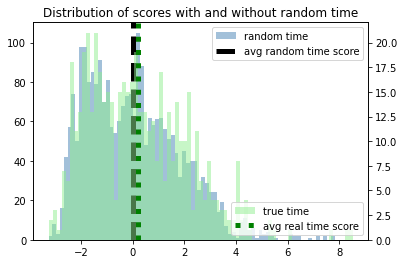

In [23]:
fig, ax = plt.subplots()

ax.set_title("Distribution of scores with and without random time")

_, _, p1 = ax.hist(all_random, color="steelblue", bins=75, label='random time', alpha=0.5)
p2 = ax.axvline(sum(all_random) / len(all_random), color="black", linewidth=5, linestyle="--", label='avg random time score')

ax2 = ax.twinx()

_, _, p3 = ax2.hist(all_real, color="lightgreen", bins=75, label='true time', alpha=0.5)
p4 = ax2.axvline(sum(all_real) / len(all_real), color="green", linewidth=5, linestyle=":", label='avg real time score')

ax.legend(loc=0)
ax2.legend(loc=4)

plt.show()